# QC for chicken A1 old genome

## Imports

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import os
import bbknn
from pathlib import Path

## Single cell settings

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(80)
sc.settings._file_format_figs = 'pdf'
sc.settings.savefigs = False
use_first_n_samples = 0
full_sparse = False

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_22748\3661074169.py:2: FutureWarning: The specified parameters ('scanpy',) are no longer positional. Please specify them like `scanpy=80`
  sc.settings.set_figure_params(80)


## Basic QC workflow

In [3]:
adatas = []
data_names = ['control','lf','lps','pic']
main_path = '/Code/data/single_cell/animals/chicken/ca1/old_genome/'
paths = ['\\control','\\lf','\\lps','\\pic']    #...etc - Folders with matrix, features and barcodes gz files.
for path in paths:
    adata = sc.read_10x_mtx(main_path + path, var_names='gene_symbols', cache=False)    # use gene symbols for the variable names (variables-axis index)
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)

    reading \Code\data\single_cell\animals\chicken\ca1\old_genome\control\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.32 GB, difference +0.32 GB
(4115, 24356)
    reading \Code\data\single_cell\animals\chicken\ca1\old_genome\lf\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.38 GB, difference +0.06 GB
(3500, 24356)
    reading \Code\data\single_cell\animals\chicken\ca1\old_genome\lps\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: current 0.39 GB, difference +0.01 GB
(4052, 24356)
    reading \Code\data\single_cell\animals\chicken\ca1\old_genome\pic\matrix.mtx.gz
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Memory usage: 

In [4]:
adata = adatas[0].concatenate(adatas[1:], batch_categories=data_names, batch_key='treatment')

# adata

c:\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [5]:
genes = pd.read_csv('/Code/data/single_cell/animals/eggnog_croc_chic_komo_turt.csv')
genes.dropna(subset = ['turtle gene id'], inplace=True)

genes_dict = dict(zip(genes['chicken 102 gene id'].astype('str'), genes.eggnog_name.astype('str'))) #change the column name to fit the animal

dict_multi, dict_uni = {}, {}
for d in genes_dict:
    if len(d.split(',')) != 1:
        dict_multi[d] = genes_dict[d]
    else:
        dict_uni[d] =  genes_dict[d]

multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))

    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni, **multi_result_dict}

genes_dict

{'ENSGALG00000003765': 'A1CF',
 'ENSGALG00000014128': 'A4GALT',
 'ENSGALG00000006600': 'A4GNT',
 'ENSGALG00000032843': 'AAAS',
 'ENSGALG00000002899': 'AACS',
 'ENSGALG00000010364': 'AADAC',
 'ENSGALG00000009655': 'AADAT',
 'ENSGALG00000012624': 'AAED1',
 'ENSGALG00000007887': 'AAGAB',
 'ENSGALG00000041911': 'AAK1',
 'ENSGALG00000041949': 'AAMDC',
 'ENSGALG00000011445': 'AAMP',
 'ENSGALG00000001955': 'AANAT',
 'ENSGALG00000001034': 'AAR2',
 'ENSGALG00000001965': 'AARS',
 'ENSGALG00000035337': 'AARS2',
 'ENSGALG00000013764': 'AASDH',
 'ENSGALG00000027981': 'AASDHPPT',
 'ENSGALG00000008953': 'AASS',
 'ENSGALG00000005420': 'AATF',
 'ENSGALG00000006901': 'AATK',
 'ENSGALG00000007334': 'ABAT',
 'ENSGALG00000015433': 'ABCA1',
 'ENSGALG00000003553': 'ABCA12',
 'ENSGALG00000036894': 'ABCA2',
 'ENSGALG00000037837': 'ABCA3',
 'ENSGALG00000004333': 'ABCA5',
 'ENSGALG00000046825': 'ABCA7',
 'ENSGALG00000021399': 'ABCA9',
 'ENSGALG00000011096': 'ABCB10',
 'ENSGALG00000010891': 'ABCB11',
 'ENSGALG000

In [6]:
adata.obs

,treatment
AAACCCACACACAGAG-1-control,control
AAACCCACAGCATCTA-1-control,control
AAACCCAGTCGAAGCA-1-control,control
AAACCCAGTTCGGTTA-1-control,control
AAACCCATCTGTGCAA-1-control,control
...,...
TTTGTTGCATAGAAAC-1-pic,pic
TTTGTTGGTCGGCACT-1-pic,pic
TTTGTTGGTCGTTTCC-1-pic,pic
TTTGTTGGTGTTACTG-1-pic,pic


In [7]:
adata.var

,gene_ids,feature_types
ENSGALG00000054818,ENSGALG00000054818,Gene Expression
ENSGALG00000053455,ENSGALG00000053455,Gene Expression
ENSGALG00000045540,ENSGALG00000045540,Gene Expression
ENSGALG00000051297,ENSGALG00000051297,Gene Expression
ENSGALG00000042023,ENSGALG00000042023,Gene Expression
...,...,...
ENSGALG00000050630,ENSGALG00000050630,Gene Expression
ENSGALG00000047001,ENSGALG00000047001,Gene Expression
ENSGALG00000048503,ENSGALG00000048503,Gene Expression
ENSGALG00000047099,ENSGALG00000047099,Gene Expression


In [8]:
adata.var.set_index('gene_ids', inplace=True) 
adata.var['gene_ids'] = adata.var.index

adata.var.drop(columns='feature_types', inplace=True)
adata.var.rename(genes_dict, inplace=True)

In [9]:
adata.var

,gene_ids
gene_ids,
IMPDH2,ENSGALG00000054818
ENSGALG00000053455,ENSGALG00000053455
CLEC2B,ENSGALG00000045540
CLEC2B,ENSGALG00000051297
CLEC2B,ENSGALG00000042023
...,...
ENSGALG00000050630,ENSGALG00000050630
ENSGALG00000047001,ENSGALG00000047001
ENSGALG00000048503,ENSGALG00000048503


In [10]:
# This code identifies duplicate variable names, iterates through them, and adds suffixes to make them unique from the first occurrence.
# Please make sure to replace adata with your actual AnnData object.

# Keep in mind that Scanpy's functionality may evolve, so it's a good idea to check the documentation or release notes
# for any updates related to making variable names unique starting from the first occurrence in more recent versions of Scanpy.

# Get a Series of variable (gene) names
var_names_series = pd.Series(adata.var_names)

# Identify duplicate variable names
duplicate_var_names = var_names_series[var_names_series.duplicated(keep='first')]

# Iterate through duplicates and add suffixes to make them unique from the first occurrence
for duplicate_name in duplicate_var_names:
    count = 1
    indices = var_names_series[var_names_series == duplicate_name].index
    for idx in indices:
        var_names_series[idx] = f'{duplicate_name}_{count}'
        count += 1

# Update the AnnData object with the unique variable names
adata.var_names = var_names_series.values

adata.var_names

Index(['IMPDH2_1', 'ENSGALG00000053455', 'CLEC2B_1', 'CLEC2B_2', 'CLEC2B_3',
       'ENSGALG00000047594', 'ENSGALG00000049206', 'DHRS2', 'LRRC16B',
       'ENSGALG00000052679',
       ...
       'ENSGALG00000051074', 'ENSGALG00000046800', 'ENSGALG00000054249',
       'ENSGALG00000050580', 'ENSGALG00000049605', 'ENSGALG00000050630',
       'ENSGALG00000047001', 'ENSGALG00000048503', 'ENSGALG00000047099',
       'ENSGALG00000051745'],
      dtype='object', length=24356)

Creating a raw adata annotated with the metadata created in downstream processing 

## Genes and cells filtration 

### Highly expressed genes ( = top 20 genes)

normalizing counts per cell
    finished (0:00:00)


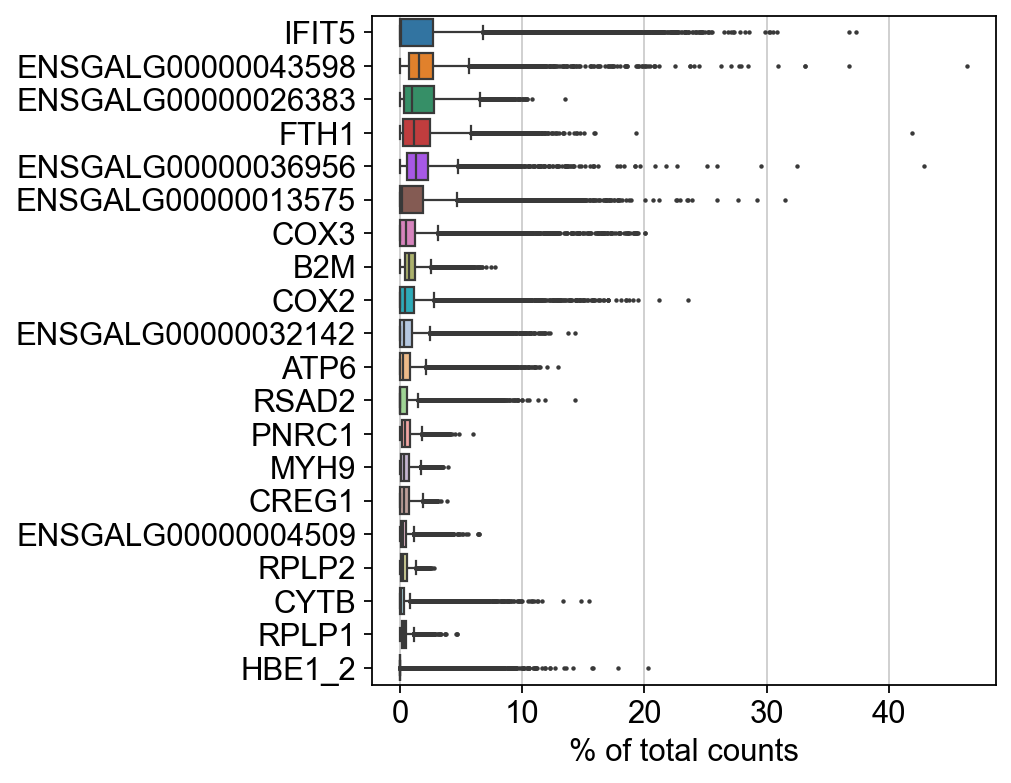

In [11]:
# Shows the genes that yield the highest fraction of counts in each single cell, across all cells.

sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
adata_copy = adata.copy()

In [13]:
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape) 

filtered out 61 cells that have less than 100 genes expressed
filtered out 9595 genes that are detected in less than 3 cells
(19220, 14761)


### Mitochondrial QC and general measures

Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [14]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1-1','ND1':'MT-ND1-2','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L-1':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace=True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [15]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

In [16]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

### Scatter plots of QC metrics

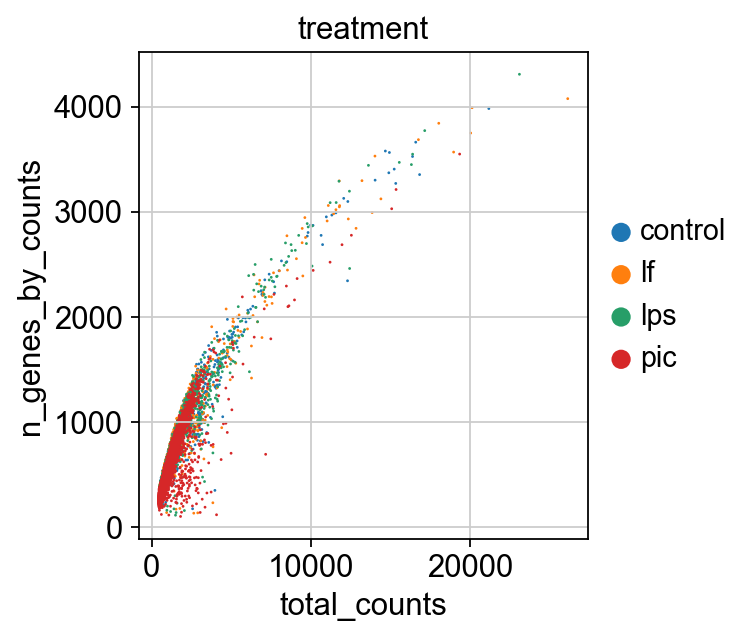

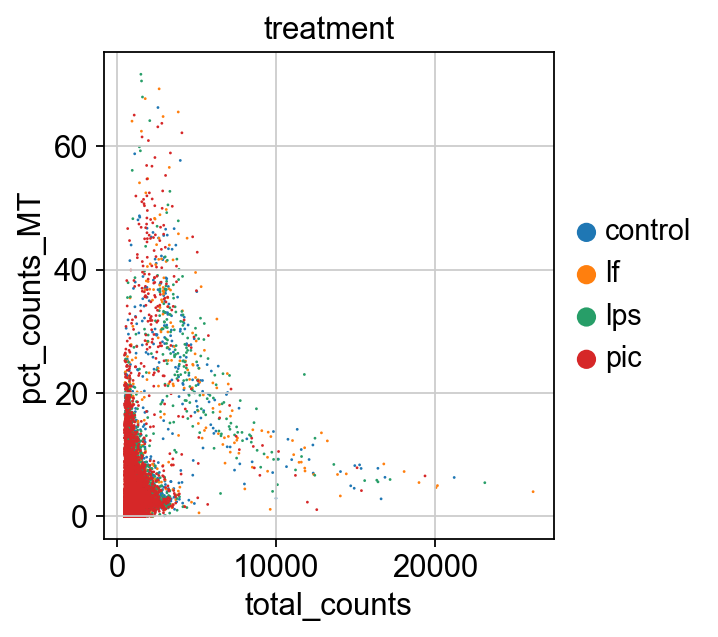

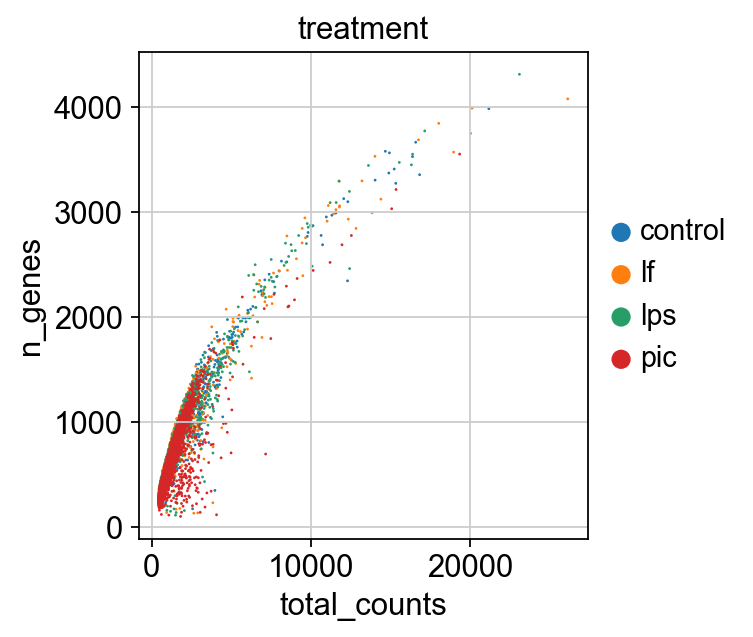

In [17]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='treatment')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='treatment', save=True)

Actually do the filtering by slicing the AnnData object - By pct_counts_MT  and by total_counts /n_genes_by_counts or even n_genes

In [18]:
adata = adata[adata.obs.pct_counts_MT < 20] 
adata = adata[adata.obs.total_counts < 5000, :] # If filtering outliers (<0.1% of cells)

## Doublet analysis and filtering

In [19]:
import scrublet as scr

def scrub(adatas, adata, adata_names):  # based on raw individual samples. 
    print('Before scrublet: ', adata.shape[0])
    doub_index = []
    barcodes = []
    for data,name in zip(adatas,adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets' + name + ' :', data.obs[data.obs['doublet_scores'] > 0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] < 0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode + '-' + name)

    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ', adata.shape[0])
    return adata

Before scrublet:  18426
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 3.8%
Estimated detectable doublet fraction = 60.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.3%
Elapsed time: 3.8 seconds
Doubletscontrol : 221
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.27
Detected doublet rate = 4.4%
Estimated detectable doublet fraction = 59.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.3%
Elapsed time: 2.8 seconds
Doubletslf : 185
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 5.0%
Estimated detectable doublet fraction = 66.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.6%
Elapsed time: 2.9 seconds
Doubletslps : 245
normalizing counts per cell
    finished (0:00:00)
Preprocessing...


c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
c:\Python\Python310\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 3.6%
Estimated detectable doublet fraction = 48.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.4%
Elapsed time: 6.0 seconds
Doubletspic : 506
After scrublet:  17312


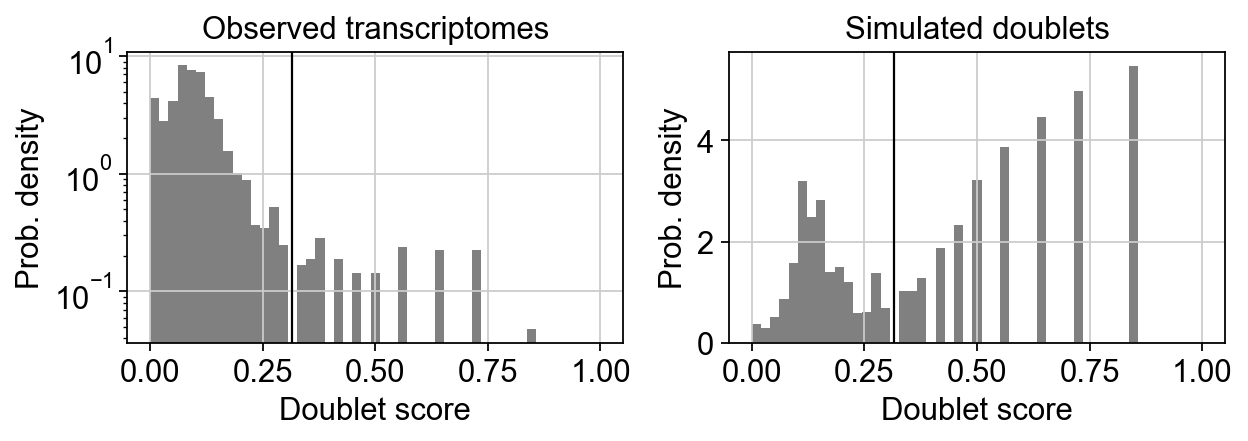

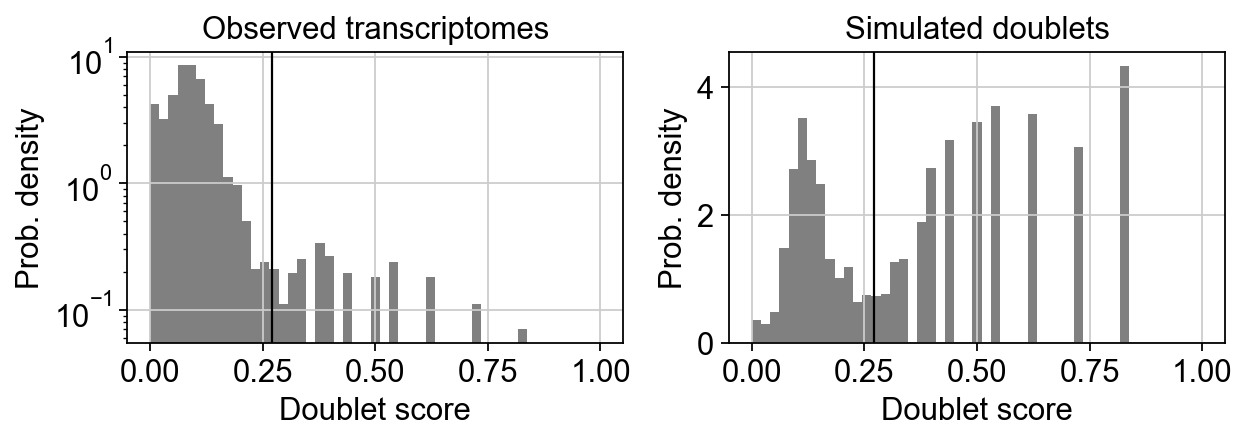

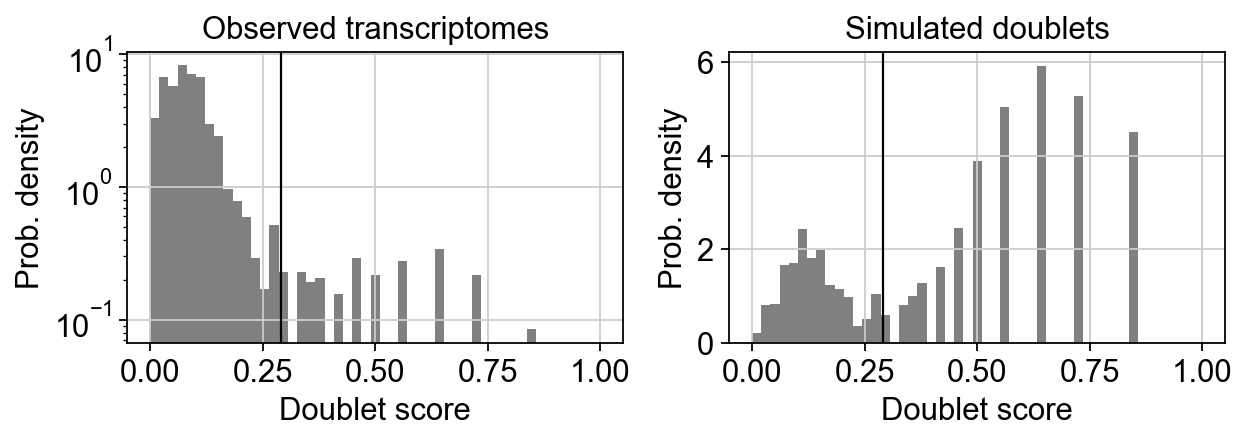

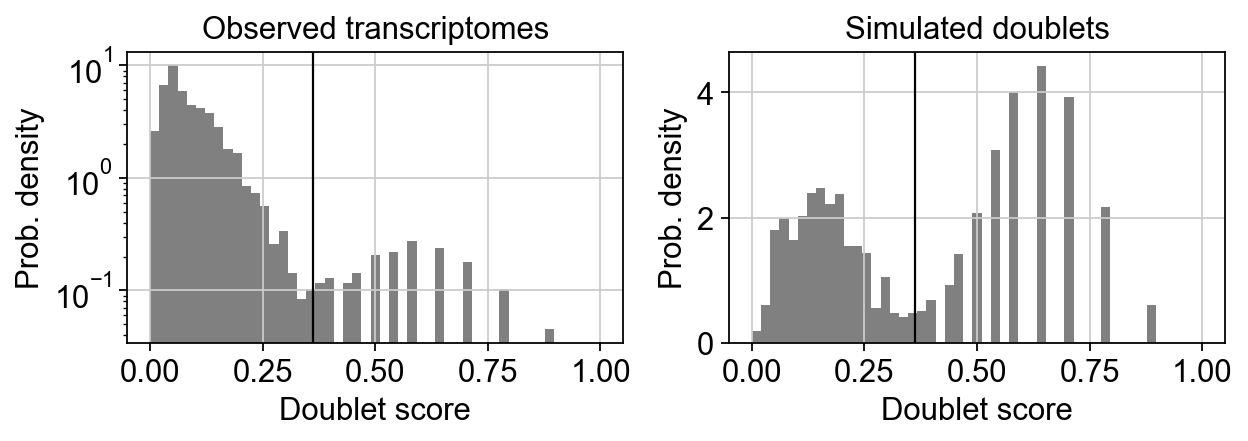

In [20]:
adata = scrub(adatas, adata, data_names)

## Cell cycle scoring

download Cell cycle txt: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [21]:
cell_cycle_genes = [x.strip() for x in open(r'/Code/data/single_cell/animals/regev_lab_cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [22]:
adata.var_names

Index(['ENSGALG00000053455', 'CLEC2B_1', 'CLEC2B_2', 'CLEC2B_3', 'DHRS2',
       'LRRC16B', 'ENSGALG00000052679', 'CLEC2B_4', 'ENSGALG00000048560',
       'CLEC2B_5',
       ...
       'ENSGALG00000048147', 'ENSGALG00000047428', 'ENSGALG00000049072',
       'ENSGALG00000053368', 'ENSGALG00000041352', 'ENSGALG00000050667',
       'ENSGALG00000054249', 'ENSGALG00000047001', 'ENSGALG00000048503',
       'ENSGALG00000047099'],
      dtype='object', length=14761)

In [23]:
g2m_genes

['HMGB2',
 'CDK1',
 'NUSAP1',
 'UBE2C',
 'TPX2',
 'TOP2A',
 'NDC80',
 'NUF2',
 'CKS1B',
 'MKI67',
 'TMPO',
 'TACC3',
 'FAM64A',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'HJURP',
 'HN1',
 'CDC20',
 'TTK',
 'KIF2C',
 'RANGAP1',
 'DLGAP5',
 'CDCA2',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'ANLN',
 'LBR',
 'CKAP5',
 'CENPE',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5']

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    717 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    717 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


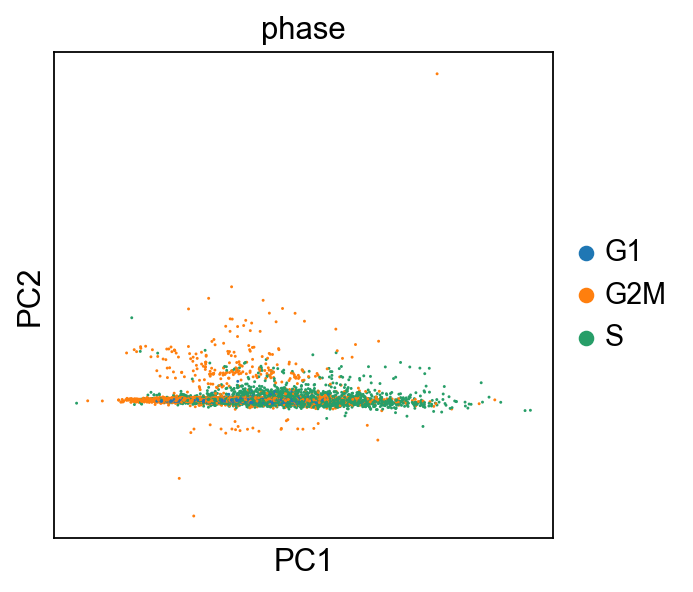

C:\Users\TzachiHNB2\AppData\Local\Temp\ipykernel_22748\1917813240.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()


In [24]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase', save=True)
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 17312 × 14761
    obs: 'treatment', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'n_cells', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'treatment_colors'

In [26]:
adata.var

,gene_ids,n_cells,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
ENSGALG00000053455,ENSGALG00000053455,7,False,7,0.000364,99.963580,7.0
CLEC2B_1,ENSGALG00000045540,2309,False,2309,0.134651,87.986472,2588.0
CLEC2B_2,ENSGALG00000051297,1626,False,1626,0.093392,91.540062,1795.0
CLEC2B_3,ENSGALG00000042023,6008,False,6008,0.413632,68.740895,7950.0
DHRS2,ENSGALG00000029624,94,False,94,0.005411,99.510926,104.0
...,...,...,...,...,...,...,...
ENSGALG00000050667,ENSGALG00000050667,24,False,24,0.001405,99.875130,27.0
ENSGALG00000054249,ENSGALG00000054249,20,False,20,0.001041,99.895942,20.0
ENSGALG00000047001,ENSGALG00000047001,4,False,4,0.000208,99.979188,4.0
ENSGALG00000048503,ENSGALG00000048503,67,False,67,0.003538,99.651405,68.0


## Saving adata

In [27]:
adata.write(r'/Code/data/single_cell/animals/chicken/ca1/old_genome/''chicken_a1_after_qc.h5ad')

## Preparing files to be opened in R studio

In [ ]:
# Preparing files to be opened in R studio

matrix_dense = adata.X.toarray()

# Create a DataFrame from the dense array with observation names as index and variable names as columns
matrix_df = pd.DataFrame(matrix_dense, index=adata.obs_names, columns=adata.var_names)

# Save the DataFrame to a CSV file
matrix_df.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''matrix_new.csv')
print('matrix file is transformed')

#save obs as scv
adata.obs.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''obs_new.csv')
print('obs file is transformed')

# Save variable data to a CSV file
adata.var.to_csv(r'/Code/data/single_cell/animals/turtle/turtle_3/''var_new.csv')
print('var file is transformed')